In [1]:
import tensorflow as tf
from tensorflow import keras 

In [2]:
import os 
import numpy as np
import random
import matplotlib.pyplot as plt 
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.transform import resize 

In [3]:
seed=42
np.random.seed=seed

In [4]:
TRAIN_PATH='/kaggle/input/data-science-bowl2018/stage1_train'
TEST_PATH='/kaggle/input/data-science-bowl2018/stage1_test'

In [5]:
train_ids=next(os.walk(TRAIN_PATH))[1]
test_ids=next(os.walk(TEST_PATH))[1]

In [6]:
inputs=keras.layers.Input((128,128,3))
s=keras.layers.Lambda(lambda x:x/255)(inputs) # converting the input values into floating points 

In [7]:
#create an empty array with the image dimension 
X_train=np.zeros((len(train_ids),128,128,3),dtype=np.uint8)
Y_train=np.zeros((len(train_ids),128,128,3),dtype=np.bool_)

In [8]:
print(len(train_ids))
print(len(test_ids))

670
65


In [9]:
print("Resizing training images and masks")
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=TRAIN_PATH+'/'+id_
    img=imread(path+'/images/'+id_+'.png')[:,:,:3]
    img=resize(img,(128,128),mode='constant',preserve_range=True)
    X_train[n]=img # fill empty X_train with the values from images 
    mask=np.zeros((128,128,1),dtype=bool)
    for mask_file in next(os.walk(path+'/masks/'))[2]:
        mask_=imread(path+'/masks/'+mask_file)
        mask_=np.expand_dims(resize(mask_,(128,128),mode='constant',preserve_range=True),axis=-1)
        mask=np.maximum(mask,mask_)
        
    Y_train[n]=mask

Resizing training images and masks


100%|██████████| 670/670 [06:58<00:00,  1.60it/s]


In [10]:
#test images
X_test=np.zeros((len(test_ids),128,128,3),dtype=np.uint8)
sizes_test=[]
print("Resizing test images")
for n,id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    path=TEST_PATH+'/'+id_
    img=imread(path+'/images/'+id_+'.png')[:,:,:3]
    sizes_test.append([img.shape[0],img.shape[1]])
    img=resize(img,(128,128),mode='constant',preserve_range=True)
    X_test[n]=img
    
print("Done")

Resizing test images


100%|██████████| 65/65 [00:02<00:00, 26.23it/s]

Done


In [11]:
# Ensure Y_train has a single channel
Y_train = np.expand_dims(np.squeeze(Y_train[:,:,:,0]), axis=-1)  # Convert (128, 128, 3) -> (128, 128, 1)


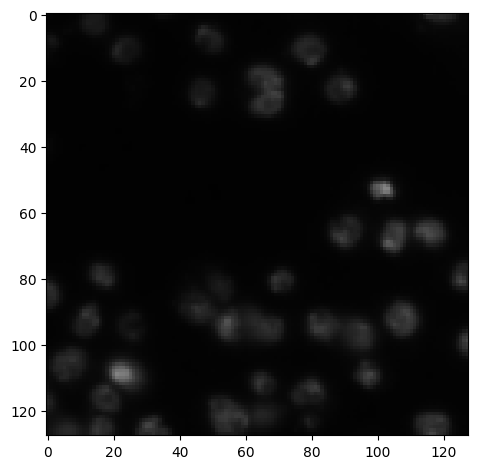

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


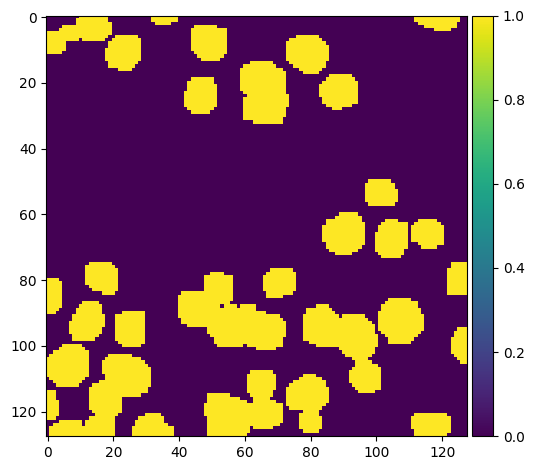

In [12]:
image_x=random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]).astype(np.uint8))
plt.show()

In [13]:
#Contraction Path
c1=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1=keras.layers.Dropout(0.1)(c1)
c1=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1=keras.layers.MaxPooling2D((2,2))(c1)

c2=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2=keras.layers.Dropout(0.1)(c2)
c2=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2=keras.layers.MaxPooling2D((2,2))(c2)

c3=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3=keras.layers.Dropout(0.2)(c3)
c3=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3=keras.layers.MaxPooling2D((2,2))(c3)

c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = keras.layers.Dropout(0.2)(c4)
c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = keras.layers.Dropout(0.3)(c5)
c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [14]:
# Expansive Path
u6=keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6=keras.layers.concatenate([u6,c4])
c6=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6=keras.layers.Dropout(0.2)(c6)
c6=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7=keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7=keras.layers.concatenate([u7,c3])
c7=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7=keras.layers.Dropout(0.2)(c7)
c7=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = keras.layers.Dropout(0.1)(c8)
c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = keras.layers.Dropout(0.1)(c9)
c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


In [15]:
outputs=keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)


In [16]:
model=keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#Model checkpoint 
checkpointer=keras.callbacks.ModelCheckpoint('model_for_nuclei.keras',verbose=1,save_best_only=True)

In [18]:
callbacks=[
    keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
    keras.callbacks.TensorBoard(log_dir='logs'),
    keras.callbacks.ModelCheckpoint('model_for_nuclei.keras',verbose=1,save_best_only=True)
]

In [19]:
result=model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=15,callbacks=callbacks)

Epoch 1/15


I0000 00:00:1726591904.943838      65 service.cc:145] XLA service 0x7afcc4003620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726591904.943908      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726591922.616688      65 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusi

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6927 - loss: 0.6412

I0000 00:00:1726591940.029160      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 4 bytes spill stores, 12 bytes spill loads




Epoch 1: val_loss improved from inf to 0.46453, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 519ms/step - accuracy: 0.6937 - loss: 0.6392 - val_accuracy: 0.7539 - val_loss: 0.4645
Epoch 2/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7632 - loss: 0.3507
Epoch 2: val_loss improved from 0.46453 to 0.26452, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7643 - loss: 0.3499 - val_accuracy: 0.9054 - val_loss: 0.2645
Epoch 3/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9116 - loss: 0.2385
Epoch 3: val_loss improved from 0.26452 to 0.20099, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9119 - loss: 0.2376 - val_accuracy: 0.9277 - val_loss: 0.2010
Epoch 4/15
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9301 - loss: 0.1918
Epoch 4: val_loss improved from 0.20099 to 0.13618, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms

In [20]:
idx=random.randint(0,len(X_train))

preds_train=model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val=model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
preds_test=model.predict(X_test,verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step


In [21]:
# threshold the training predictions 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

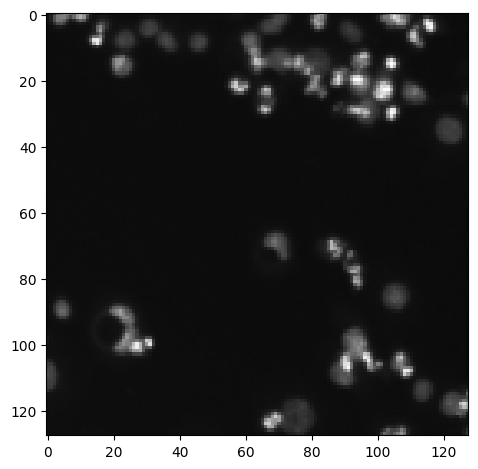

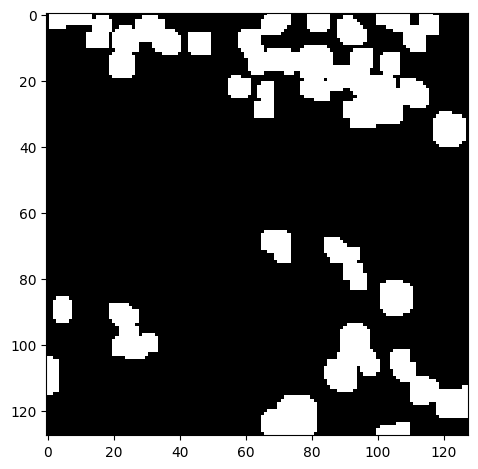

/opt/conda/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


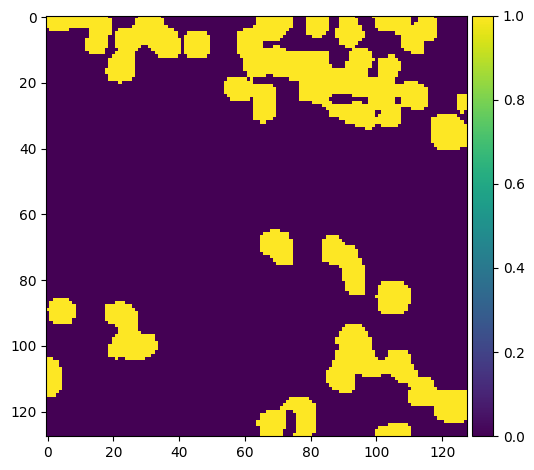

In [22]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

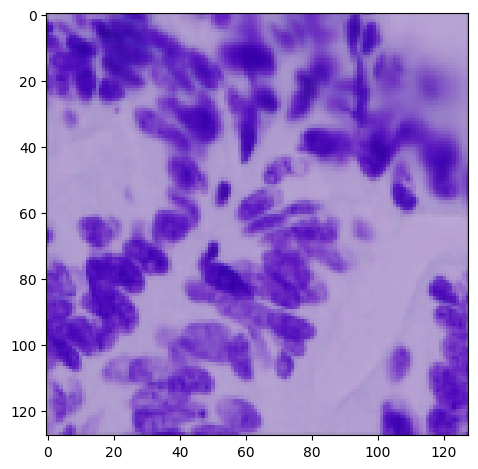

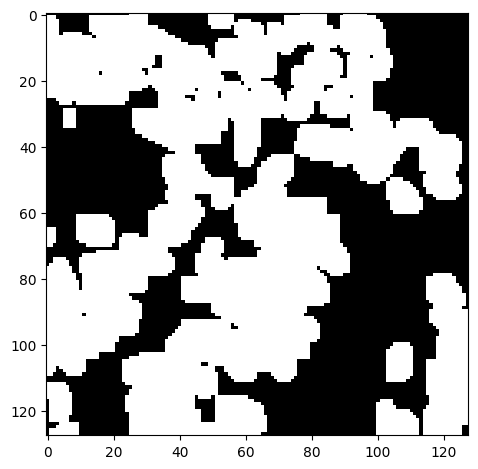

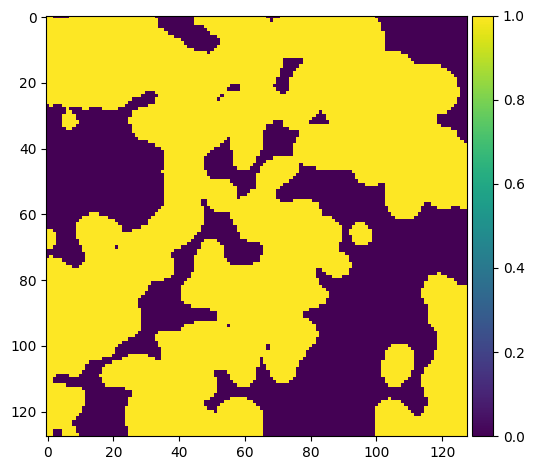

In [23]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

